In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

In [2]:
df = pd.read_csv('./data/train.csv', index_col=0)



In [3]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.shape

(1460, 80)

In [5]:
# Determine which columns are numeric and which ones are characters
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
character_columns = df.select_dtypes(include=['object']).columns.tolist()
print('Numeric columns:', numeric_columns)
print('String type columns:', character_columns)

Numeric columns: ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
String type columns: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'Ga

In [6]:
df.describe().T.shape

(37, 8)

## Exploring data:

### Numeric vs Categorical
Some numeric columns essentially represent categorical data, especially if they have a limited set of unique values. We can identify the numeric columns that don't represent categorical data by checking the number of unique values in each numeric column. If a column has more than a certain threshold of unique values, we'll consider it as a true numeric column.

Let's list the numeric columns that have more than, say, 15 unique values, which would suggest that they don't represent categorical data.

In [7]:
def get_numeric_columns(df):
    # Identify numeric columns
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    # Define the threshold
    threshold = 15

    # Identify numeric columns with unique values greater than the threshold
    true_numeric_columns = [col for col in numeric_columns if df[col].nunique() > threshold]

    return true_numeric_columns
print(get_numeric_columns(df))

['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'MiscVal', 'SalePrice']


Finding the columns with outliers:

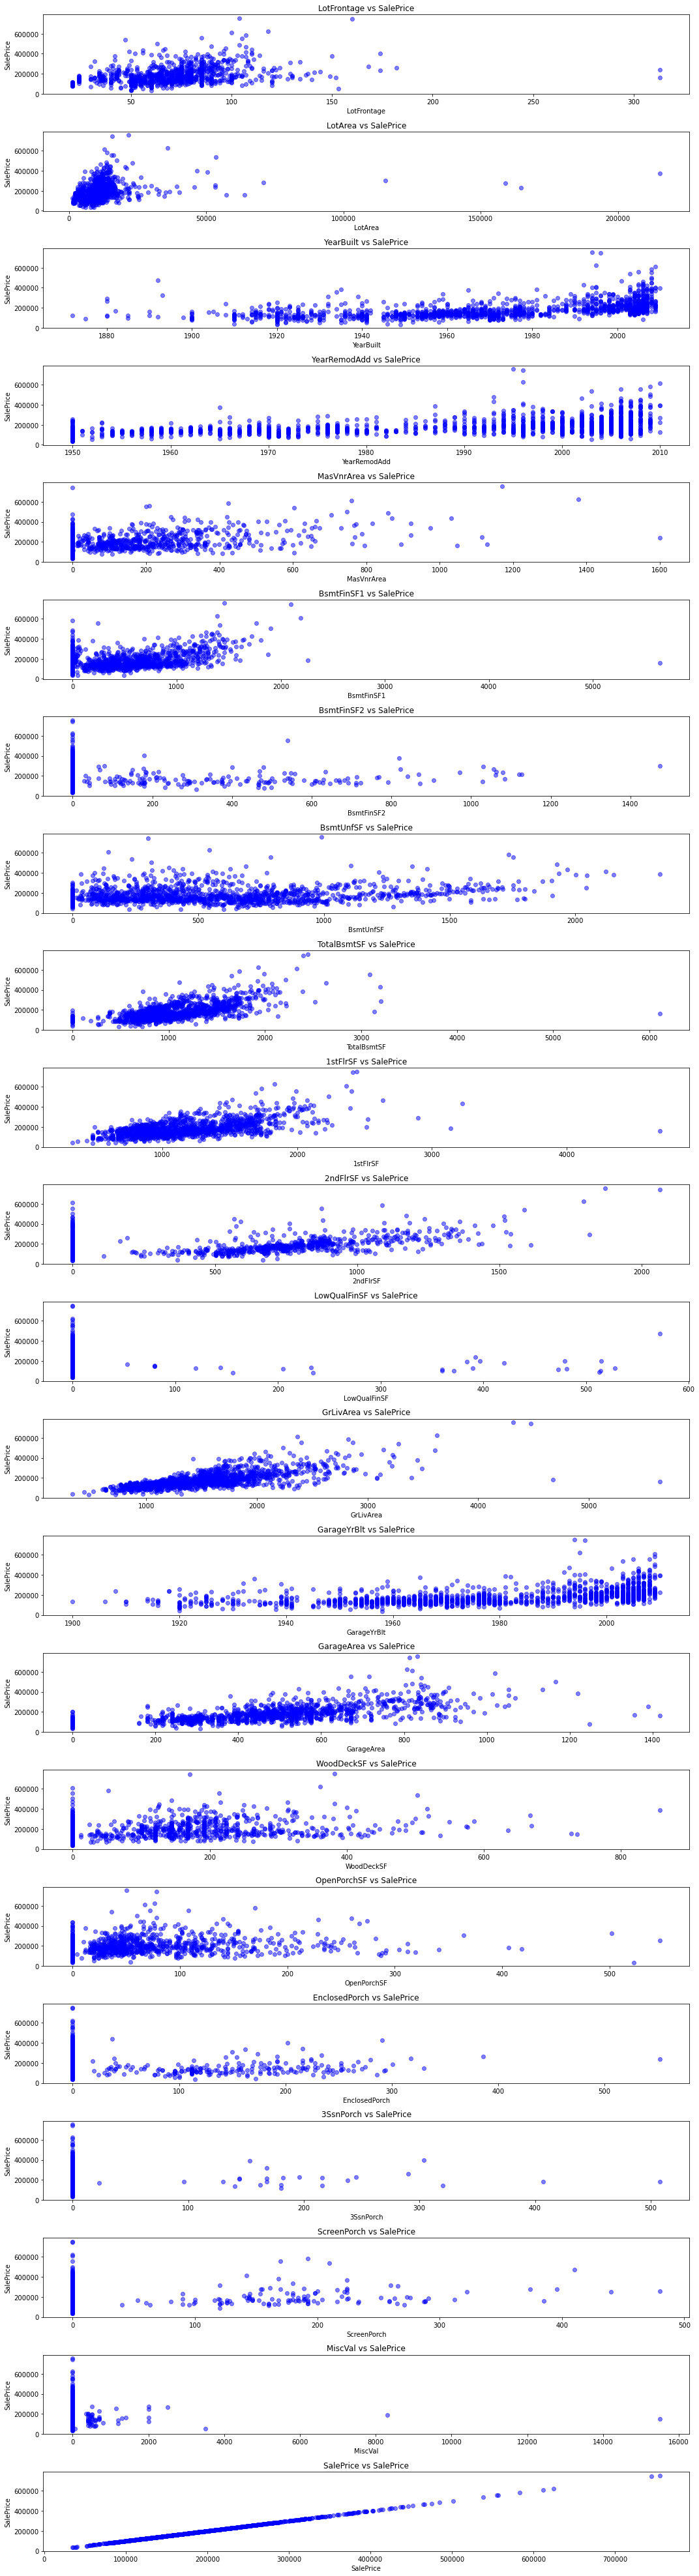

In [8]:
true_numeric_columns = get_numeric_columns(df)
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
def plot_ves_one(featur, columns_of_interest):
    # Plot the columns with true numeric values against SalePrice
    plt.figure(figsize=(15, 2.5 * len(columns_of_interest)))
    for i, col in enumerate(columns_of_interest, 1):
        plt.subplot(len(columns_of_interest), 1, i)
        plt.scatter(df[col], df[featur], alpha=0.5, color='blue')
        plt.title(col + f" vs {featur}")
        plt.ylabel(featur)
        plt.xlabel(col)
        plt.tight_layout()

    plt.show()
featur = 'SalePrice'
columns_of_interest = true_numeric_columns
plot_ves_one(featur, columns_of_interest)

# Collinearity

Let's see if our variable are correlated by ploting the correlation matrix.

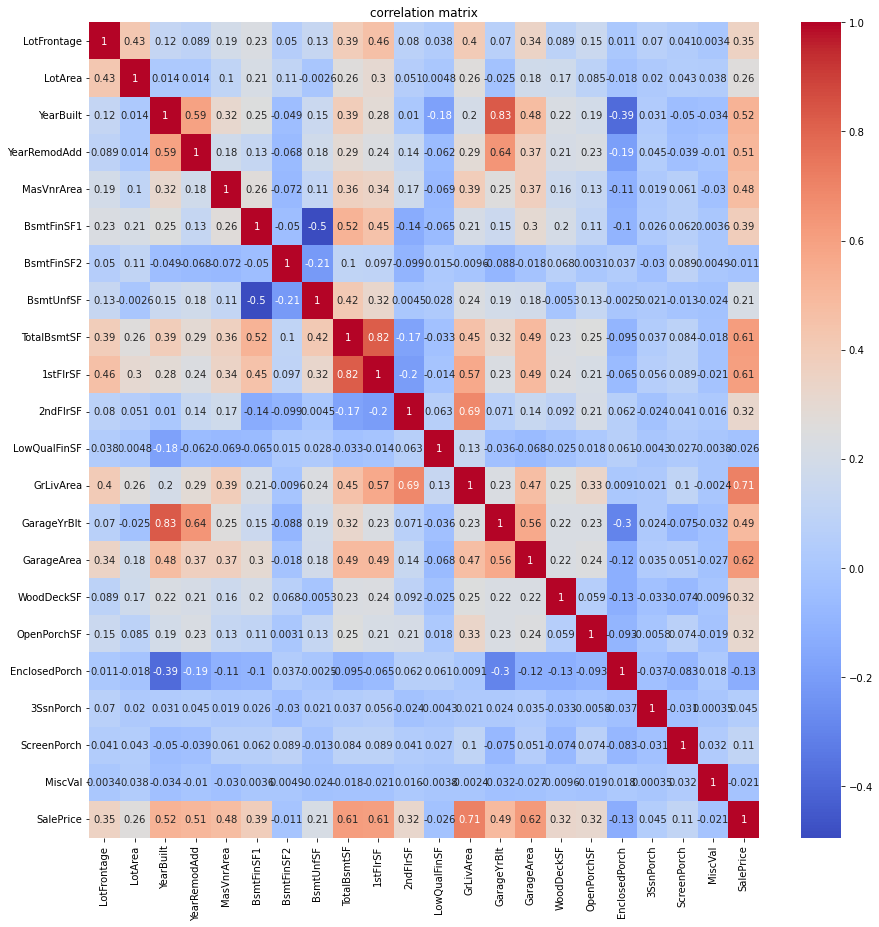

In [9]:
def plot_corr_matrix(df):
    true_numeric_columns = get_numeric_columns(df)
    corr_matrix = df[true_numeric_columns].corr()
    plt.figure(figsize=(15,15))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=true_numeric_columns, yticklabels=true_numeric_columns)

    plt.title('correlation matrix')
    plt.show()
plot_corr_matrix(df)

'YearBuilt', 'YearRemodAdd', and  'GarageYrBlt' ae highly correlated. Let's plot them:

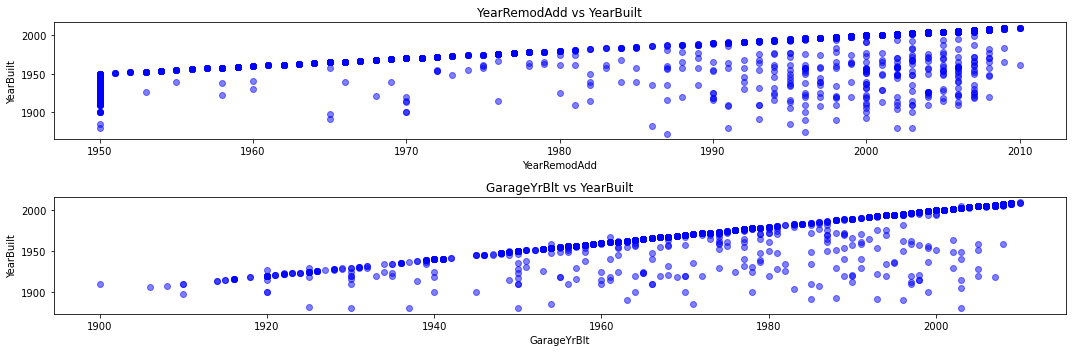

In [10]:
columns_of_int = ['YearRemodAdd', 'GarageYrBlt']
featur = 'YearBuilt'
# Plot the columns with true numeric values against SalePrice
plot_ves_one(featur, columns_of_int)

Let's have a look at thier corrlation:

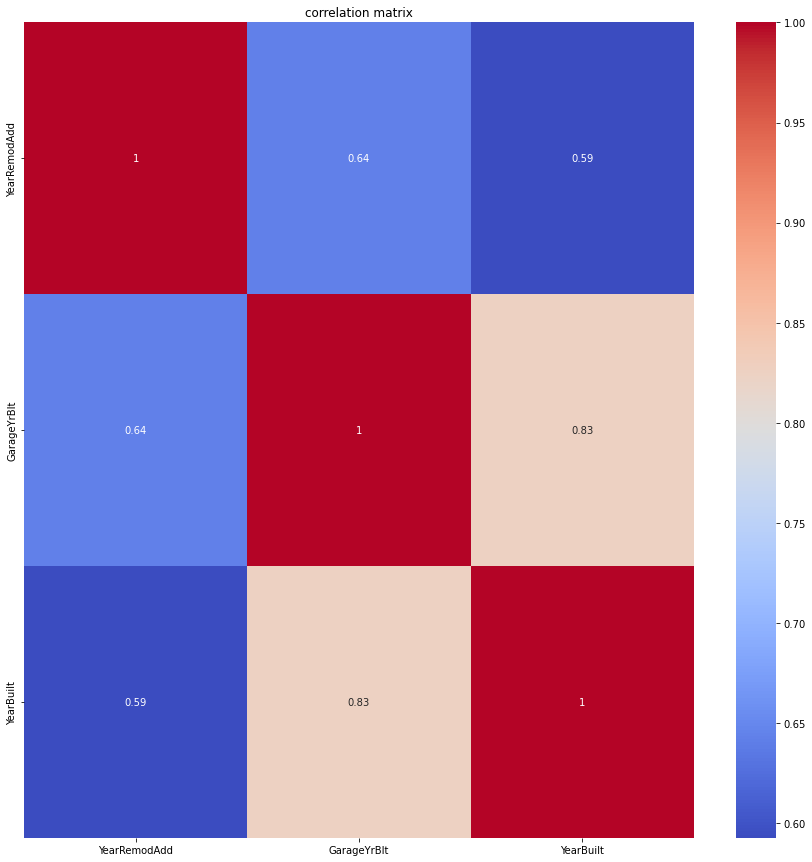

In [11]:
col_of_int = ['YearRemodAdd', 'GarageYrBlt', "YearBuilt"]
corr_matrix = df[col_of_int].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=col_of_int, yticklabels=col_of_int)

plt.title('correlation matrix')
plt.show()

Let's create new features to get rid of this correlation. One idea would be to subtract YearBuild

I applied both PCA and feature engineering techniques to address the collinearity among the features 'YearRemodAdd', 'GarageYrBlt', and 'YearBuilt'. However, these methods did not yield satisfactory results. Consequently, I opted to eliminate 'YearRemodAdd' and 'GarageYrBlt' from the dataset.


In [12]:
df.drop(['YearRemodAdd', 'GarageYrBlt'], inplace=True, axis=1)

## Colliniarity between other columns
The following columns are also have high correlation:
columns_of_int = [ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea']


Let's have a closer look at them.

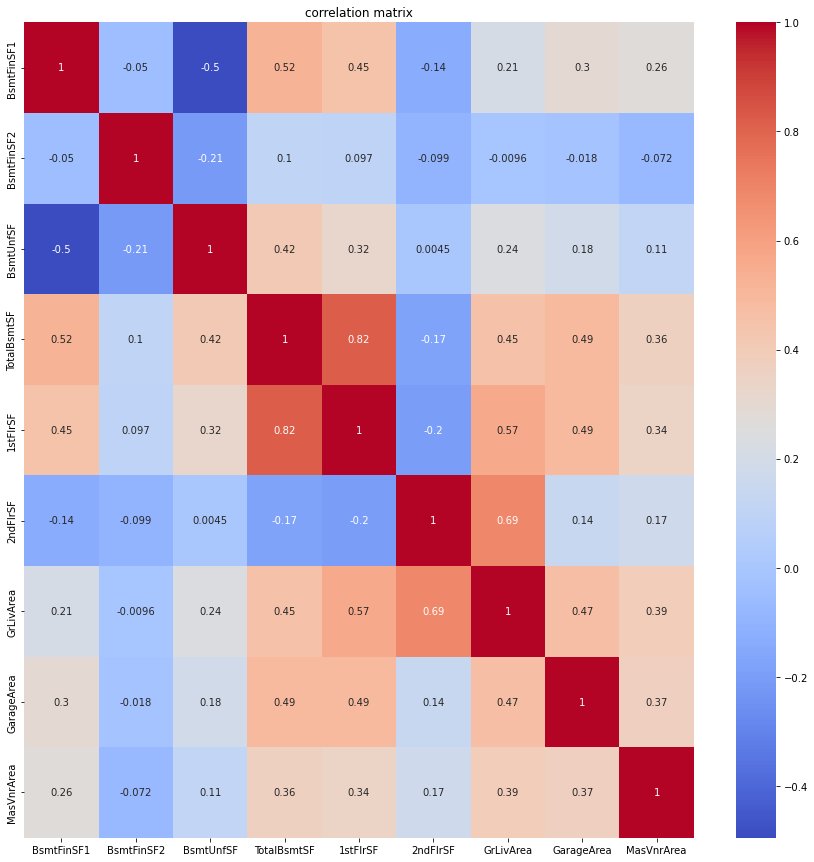

In [13]:
col_of_int = [ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']

corr_matrix = df[col_of_int].corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', xticklabels=col_of_int, yticklabels=col_of_int)

plt.title('correlation matrix')
plt.show()

The mentioned variables, which are all measured in units of area, demonstrate collinearity. To address this issue, we suggest consolidating some of these variables into a single parameter, thereby reducing collinearity.

In [14]:
columns_of_int = [ 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageArea', 'MasVnrArea']

df['Bsm'] = 0
for col in columns_of_int:
    df['Bsm'] += df[col]
df.drop(columns_of_int, axis=1, inplace=True)

print(df['Bsm'])

Id
1       5876.0
2       5508.0
3       6182.0
4       5588.0
5       7872.0
         ...  
1456    5660.0
1457    7849.0
1458    7236.0
1459    4552.0
1460    5300.0
Name: Bsm, Length: 1460, dtype: float64


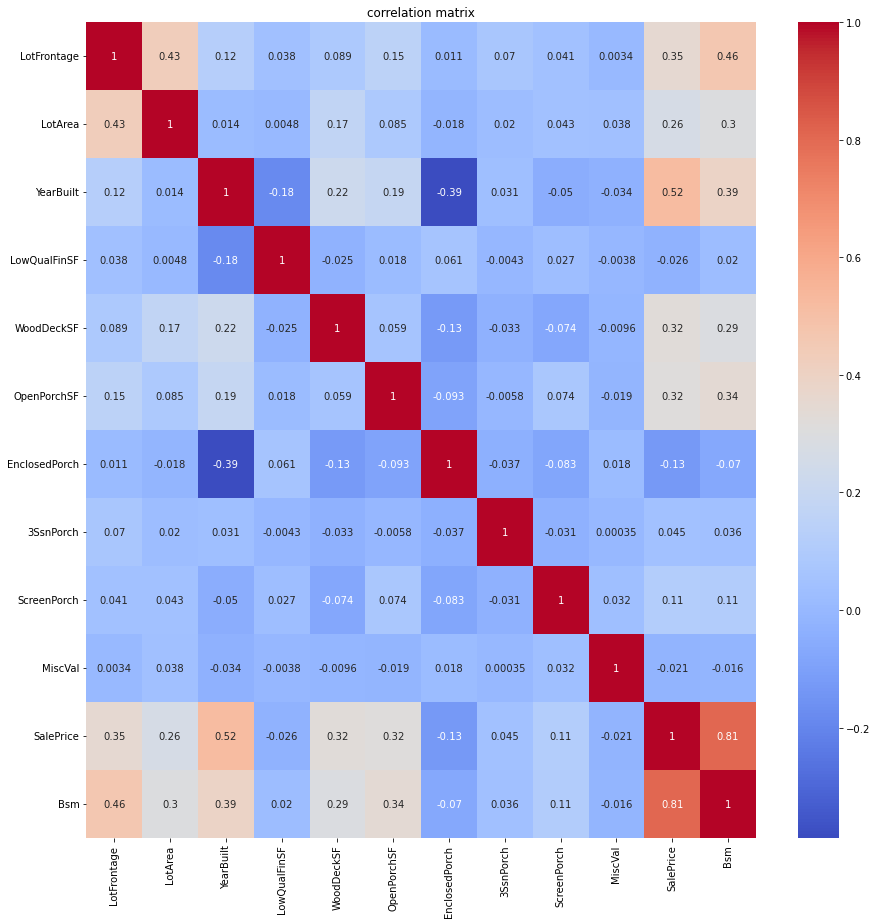

In [15]:
plot_corr_matrix(df)

The newly created parameter, Bsm, exhibits a strong correlation with the target variable, suggesting its potential as an effective predictor.

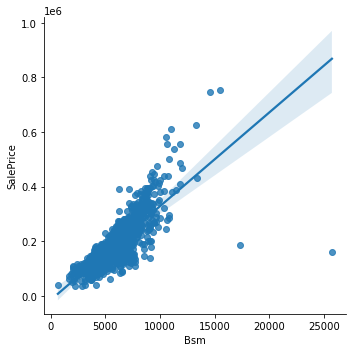

In [16]:
sns.lmplot(data=df, x="Bsm", y="SalePrice")

In [17]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bsm
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5876.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,5508.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,6182.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,5588.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,7872.0


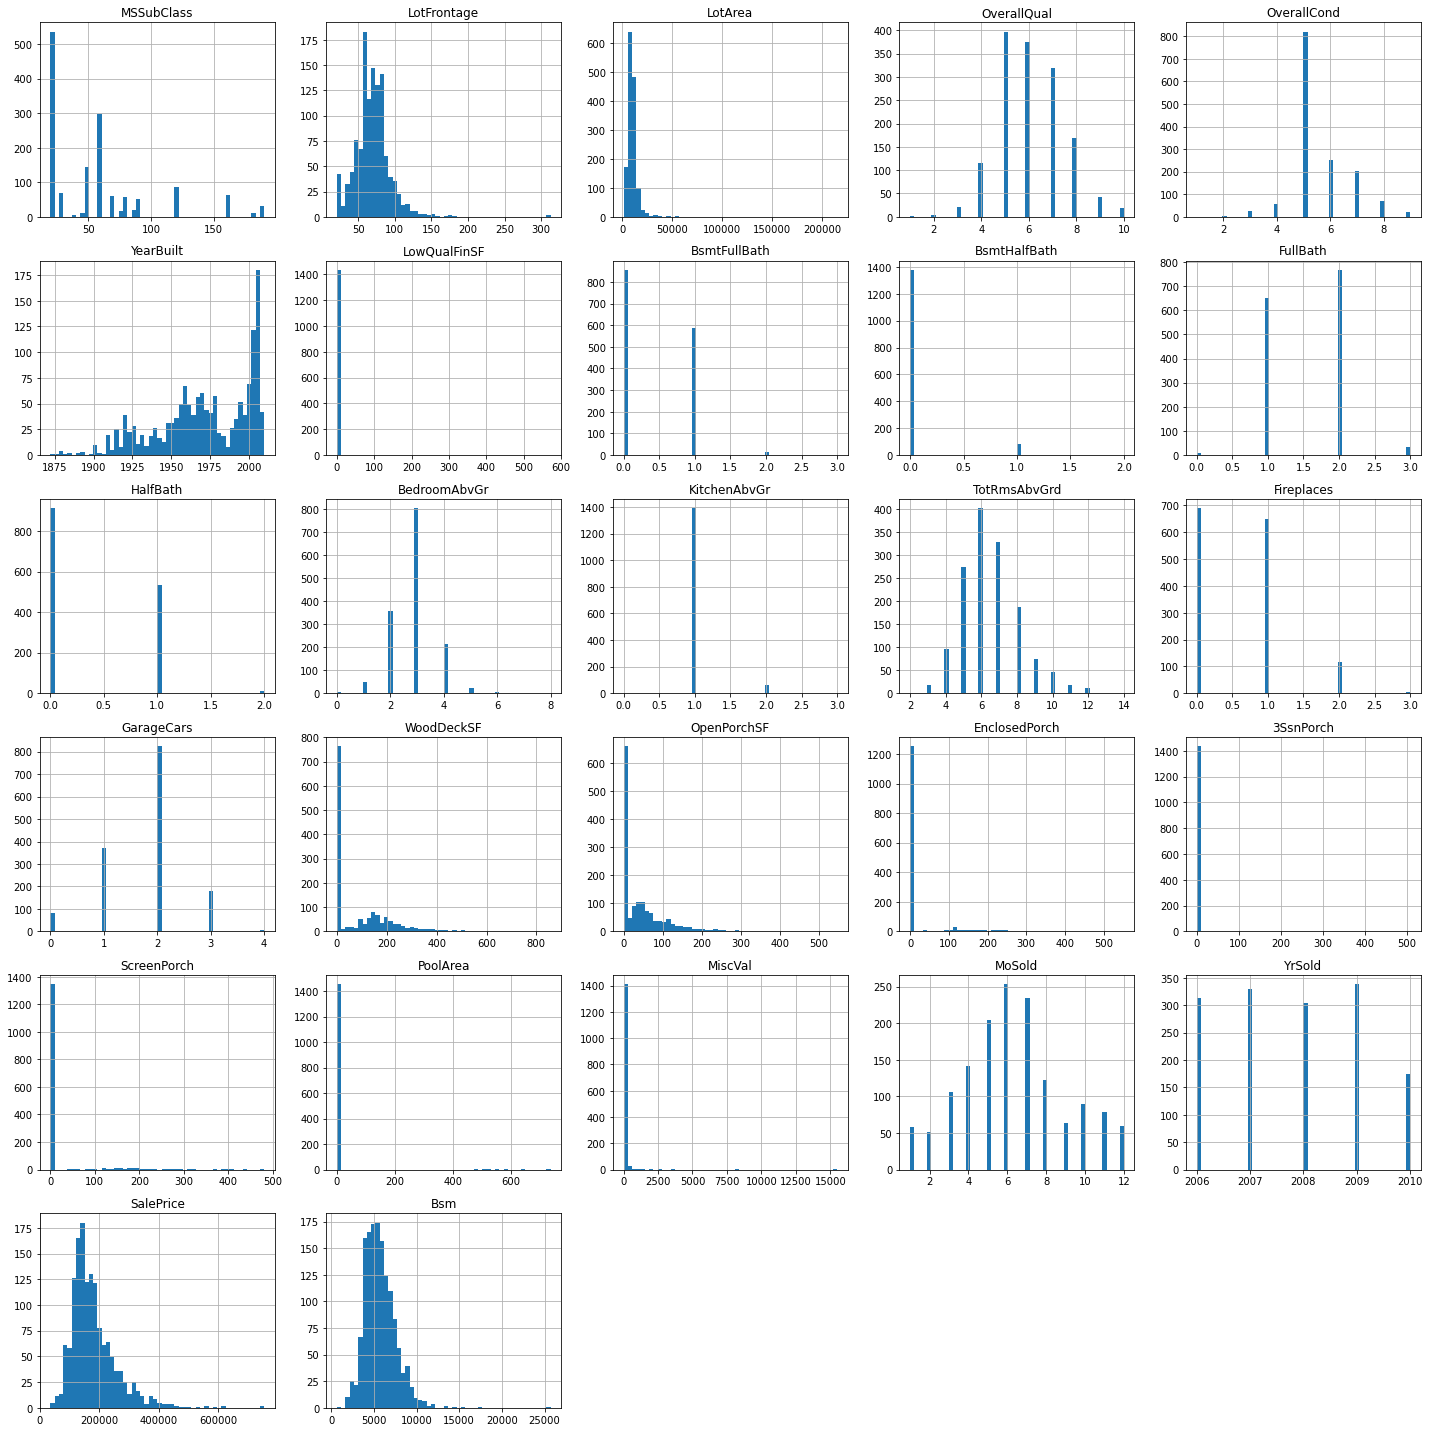

In [18]:

numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Plot histograms for the numeric columns
df[numeric_columns].hist(figsize=(20, 20), bins=50)
plt.tight_layout()
plt.show()

### Handling Data Containing Years:

For data that includes year values, we have two primary approaches:

Numeric Data: Treat the year as a continuous number.
Categorical Data: Treat the year as distinct categories.
To simplify the choice between these two methods, we can introduce a parameter: 

In [19]:
category_year = False


If category_year is True, columns containing year values are transformed into categorical ones, and necessary adjustments are made to the main dataframe.

Conversely, if category_year is False, we treat the year as numeric data and the dataframe remains as is.

In [20]:
if category_year:
    # we need to use YearBuilt later so we save it here
    year_built = df['YearBuilt']
    
    # Convert the columns 'YearBuilt' and 'YearRemodAdd' into dummy variables
    dummy_yearbuilt = pd.get_dummies(df['YearBuilt'], prefix='YearBuilt', drop_first=True)


    # Update the dataframe by adding the dummy columns and removing the original columns
    df_updated = pd.concat([df, dummy_yearbuilt], axis=1)
    df_updated.drop(['YearBuilt'], axis=1, inplace=True)
    df = df_updated
    # remove 'YearBuilt', 'YearRemodAdd' from true_numeric_columns
#     true_numeric_columns = [col for col in true_numeric_columns if col not in ['YearBuilt', 'YearRemodAdd']]

df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bsm
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,2,2008,WD,Normal,208500,5876.0
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,5,2007,WD,Normal,181500,5508.0
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,NaN,NaN,NaN,0,9,2008,WD,Normal,223500,6182.0
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000,5588.0
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,NaN,NaN,NaN,0,12,2008,WD,Normal,250000,7872.0


### Dealing with outliers

We'll identify outliers utilizing the Interquartile Range (IQR) technique. This method determines outlier data points based on a specified multiplier.

In [21]:
# Define the multiplier value for IQR method
multiplier = 2.5
true_numeric_columns = get_numeric_columns(df)
# Compute the IQR values for the true numeric columns
Q1 = df[true_numeric_columns].quantile(0.25)
Q3 = df[true_numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Recompute the bounds for the outliers using the multiplier
lower_bound = Q1 - multiplier * IQR
upper_bound = Q3 + multiplier * IQR

# Identify outliers for each column
outliers = ((df[true_numeric_columns] < lower_bound) | (df[true_numeric_columns] > upper_bound))

# Count outliers for each column
outliers_count = outliers.sum()

outliers_count


LotFrontage       18
LotArea           43
YearBuilt          0
LowQualFinSF      26
WoodDeckSF         6
OpenPorchSF       32
EnclosedPorch    208
3SsnPorch         24
ScreenPorch      116
MiscVal           52
SalePrice         21
Bsm                6
dtype: int64

Removing those row cantiaining outliers

In [22]:
# Filter out the outliers
df_no_outliers = df[~outliers.any(axis=1)]

# Display the shape of the data before and after outlier removal
original_shape = df.shape[0]
after_outlier_removal_shape = df_no_outliers.shape[0]

original_shape, after_outlier_removal_shape


(1460, 995)

In [23]:
df = df_no_outliers
df.shape

(995, 70)

## Dealing with columns with numeric values containing NaN
Let's turn our attention to columns with numeric data. Are there any numeric columns that contain NaN values?

In [24]:
# Re-identify the numeric columns
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

# Identify NaN counts in numeric columns
nan_counts_numeric = df[numeric_columns].isnull().sum()
numeric_columns_with_nan = nan_counts_numeric[nan_counts_numeric > 0]

numeric_columns_with_nan


LotFrontage    174
Bsm              6
dtype: int64

For LotFrontage: replace the null values with zero.
For MasVnrArea: drop the rows containing null values.
For GarageYrBlt: Use values from YearBuilt to fill the null values


In [25]:
print(df['Bsm'].dtypes)
# Replace NaN values in LotFrontage with 0
df['LotFrontage'].fillna(0, inplace=True)
df['Bsm'].fillna(df['Bsm'].mean(), inplace=True)

print(df['Bsm'].dtypes)

float64
float64


In [26]:
# Check for any remaining NaN values in the dataframe
remaining_nans_in_df = df.isnull().sum().sum()
print(remaining_nans_in_df)

# Check for NaN values in numeric columns
numeric_nan_count = df[numeric_columns].isnull().sum()

# Filter out columns with no NaN values
numeric_nan_count = numeric_nan_count[numeric_nan_count > 0]
numeric_nan_count

4609


Series([], dtype: int64)

## Dealing with categorical columns

Let's deal with columns containg string values:

['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


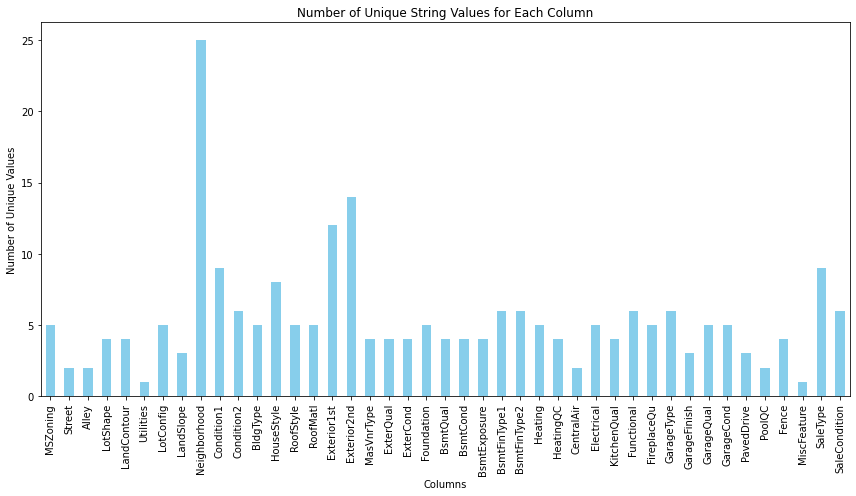

In [27]:
# Identify the character columns
character_columns = df.select_dtypes(include=['object']).columns.tolist()
print(character_columns)
# Count the number of unique values for each string column
unique_string_counts = df[character_columns].nunique()

# Plot a histogram of the counts
plt.figure(figsize=(12, 7))
unique_string_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Unique String Values for Each Column')
plt.ylabel('Number of Unique Values')
plt.xlabel('Columns')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


### Dealing with null values in categorical columns:
Let's find out which of these columns has Null values:

In [28]:
# Identify columns with NaN values and count them
nan_counts = df[character_columns].isnull().sum()
columns_with_nan = nan_counts[nan_counts > 0]
columns_with_nan

Alley           955
MasVnrType        6
BsmtQual         27
BsmtCond         27
BsmtExposure     28
BsmtFinType1     27
BsmtFinType2     28
Electrical        1
FireplaceQu     499
GarageType       52
GarageFinish     52
GarageQual       52
GarageCond       52
PoolQC          992
Fence           817
MiscFeature     994
dtype: int64

There two types:

1.For columns like "Alley", "PoolQC", "Fence", and "MiscFeature" with a high percentage of missing values, consider imputing with a value like "None" or "Unknown", given that the absence of a value might have meaning (e.g., no pool or fence).

2. For columns with fewer missing values, such as "MasVnrType" or "Electrical", consider mode imputation.


Let's examine the unique values of each of these columns:

In [29]:
# Script to print the first 10 unique values for columns in columns_with_nan
for column in columns_with_nan.index:
    unique_values = df[column].unique()[:10]
    print(f"First 10 unique values for column '{column}': {unique_values}\n")


First 10 unique values for column 'Alley': [nan 'Pave' 'Grvl']

First 10 unique values for column 'MasVnrType': ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]

First 10 unique values for column 'BsmtQual': ['Gd' 'Ex' 'TA' nan 'Fa']

First 10 unique values for column 'BsmtCond': ['TA' nan 'Gd' 'Fa' 'Po']

First 10 unique values for column 'BsmtExposure': ['No' 'Gd' 'Mn' 'Av' nan]

First 10 unique values for column 'BsmtFinType1': ['GLQ' 'ALQ' 'Rec' 'Unf' 'LwQ' 'BLQ' nan]

First 10 unique values for column 'BsmtFinType2': ['Unf' 'ALQ' 'Rec' nan 'LwQ' 'BLQ' 'GLQ']

First 10 unique values for column 'Electrical': ['SBrkr' 'FuseA' 'FuseP' 'FuseF' 'Mix' nan]

First 10 unique values for column 'FireplaceQu': [nan 'TA' 'Gd' 'Fa' 'Po' 'Ex']

First 10 unique values for column 'GarageType': ['Attchd' 'Detchd' 'BuiltIn' nan 'CarPort' '2Types' 'Basment']

First 10 unique values for column 'GarageFinish': ['RFn' 'Unf' 'Fin' nan]

First 10 unique values for column 'GarageQual': ['TA' 'Gd' nan 'Fa' 'Ex' 'Po'

It appears that all the NaN values indicate the absence of a particular feature. For instance, when a property lacks an alley, the value for the alley type is recorded as NaN. As such, we should replace these values with 'Not Available' or 'N/A'.

In [30]:
# Script to replace NaN values in columns_with_nan with 'N/A'
df[columns_with_nan.index] = df[columns_with_nan.index].fillna('N/A')

# Check if the NaN values have been replaced in these columns
remaining_nans_after_replacement = df[columns_with_nan.index].isnull().sum()

remaining_nans_after_replacement


Alley           0
MasVnrType      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Electrical      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PoolQC          0
Fence           0
MiscFeature     0
dtype: int64

In [31]:
df.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Bsm
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,N/A,Reg,Lvl,AllPub,Inside,...,N/A,N/A,N/A,0,2,2008,WD,Normal,208500,5876.0
2,20,RL,80.0,9600,Pave,N/A,Reg,Lvl,AllPub,FR2,...,N/A,N/A,N/A,0,5,2007,WD,Normal,181500,5508.0
3,60,RL,68.0,11250,Pave,N/A,IR1,Lvl,AllPub,Inside,...,N/A,N/A,N/A,0,9,2008,WD,Normal,223500,6182.0
5,60,RL,84.0,14260,Pave,N/A,IR1,Lvl,AllPub,FR2,...,N/A,N/A,N/A,0,12,2008,WD,Normal,250000,7872.0
7,20,RL,75.0,10084,Pave,N/A,Reg,Lvl,AllPub,Inside,...,N/A,N/A,N/A,0,8,2007,WD,Normal,307000,7582.0


### Creating dummy variables for the categorical columns

In [32]:
# Getting all character columns
character_columns = df.select_dtypes(include=['object']).columns.tolist()

# Checking the total number of character columns
print("Total character columns:", len(character_columns))

# Splitting the columns into batches
batch1 = character_columns[:15]
batch2 = character_columns[15:30]
batch3 = character_columns[30:]  # Ensure this index does not exceed the list length

# Print batch3 to verify its contents
print("Batch 3 columns:", batch3)

# Proceed with encoding
# Example for encoding batch1
df_batch1 = pd.get_dummies(df, columns=batch1, drop_first=True)
df_batch1.head()

Total character columns: 43
Batch 3 columns: ['KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType', 'SaleCondition']


,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,Exterior1st,Exterior2nd,MasVnrType,ExterQual,...,HouseStyle_SFoyer,HouseStyle_SLvl,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofMatl_Roll,RoofMatl_Tar&Grv,RoofMatl_WdShake,RoofMatl_WdShngl
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,VinylSd,VinylSd,BrkFace,Gd,...,0,0,1,0,0,0,0,0,0,0
2,20,80.0,9600,6,8,1976,MetalSd,MetalSd,None,TA,...,0,0,1,0,0,0,0,0,0,0
3,60,68.0,11250,7,5,2001,VinylSd,VinylSd,BrkFace,Gd,...,0,0,1,0,0,0,0,0,0,0
5,60,84.0,14260,8,5,2000,VinylSd,VinylSd,BrkFace,Gd,...,0,0,1,0,0,0,0,0,0,0
7,20,75.0,10084,8,5,2004,VinylSd,VinylSd,Stone,Gd,...,0,0,1,0,0,0,0,0,0,0


In [33]:
# # Encoding the second batch
df_batch2 = pd.get_dummies(df_batch1, columns=batch2, drop_first=True)

# # Encoding the third batch
df_final = pd.get_dummies(df_batch2, columns=batch3, drop_first=True)

# # Display the first few rows of the final dataframe with all the new dummy columns
df_final.head()



,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,LowQualFinSF,BsmtFullBath,BsmtHalfBath,FullBath,...,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,0,1,0,2,...,0,0,0,0,1,0,0,0,1,0
2,20,80.0,9600,6,8,1976,0,0,1,2,...,0,0,0,0,1,0,0,0,1,0
3,60,68.0,11250,7,5,2001,0,1,0,2,...,0,0,0,0,1,0,0,0,1,0
5,60,84.0,14260,8,5,2000,0,1,0,2,...,0,0,0,0,1,0,0,0,1,0
7,20,75.0,10084,8,5,2004,0,1,0,2,...,0,0,0,0,1,0,0,0,1,0


In [34]:
# Check if all columns in the final dataframe are numeric
all_numeric = all(df_final.dtypes.apply(lambda x: np.issubdtype(x, np.number)))

all_numeric

True

## Data splitting
We'll split the dataset into training and testing sets. The training set will be used to train the machine learning model, while the testing set will be used to evaluate its performance.

In [35]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y) definition
X = df_final.drop('SalePrice', axis=1)
y = df_final['SalePrice']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape

((796, 230), (199, 230))

## StandardScaler: 

This method standardizes features by removing the mean and scaling to unit variance. It results in features with a mean of 0 and a standard deviation of 1.

In [36]:
# Initialize the StandardScaler

scaler = StandardScaler()

# Fit the scaler to the training data and taransform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data
X_test_scaled = scaler.transform(X_test)

# Dispaly the first few rows fo the acalled training data for verifcation 
X_train_scaled[:5, :]

array([[-0.87446152,  0.34491839, -0.08715212, ..., -0.12885189,
         0.47988922, -0.3201454 ],
       [ 0.03380319, -1.79804382,  0.34962812, ..., -0.12885189,
         0.47988922, -0.3201454 ],
       [ 0.03380319,  0.79270154,  0.5402452 , ..., -0.12885189,
         0.47988922, -0.3201454 ],
       [-0.87446152, -0.19881829,  0.07311193, ..., -0.12885189,
         0.47988922, -0.3201454 ],
       [-0.87446152,  0.76071703,  0.14747688, ..., -0.12885189,
         0.47988922, -0.3201454 ]])

# Choosing a model

Before diving into complex machine learning models, it's essential to establish a simple baseline to understand the bare minimum performance we can expect. This not only sets our expectations for more advanced models but also helps ensure that the complex models add genuine value over and above the simplest predictions.
## Naive Predictors: Mean and Median
Why use the mean and median as predictors?

The mean and median are measures of central tendency in a dataset. They represent average or typical values in your data. Using these values as predictors is akin to saying, "Without any other information, what's our best guess for a given house's sale price?" The answer is often the average (mean) or the middle value (median) of all known sale prices.

How does it work?

Mean Predictor: For every test sample, predict the average SalePrice from the training data.
Median Predictor: For every test sample, predict the median SalePrice from the training data.

In [39]:


# Predict using the mean of SalePrice from the training set
mean_train = y_train.mean()
y_pred_mean = [mean_train] * len(y_test)

# Predict using the median of SalePrice from the training set
median_train = y_train.median()
y_pred_median = [median_train] * len(y_test)

# Calculate the RMSE for both predictions
rmse_mean = np.sqrt(mean_squared_error(y_test, y_pred_mean))
rmse_median = np.sqrt(mean_squared_error(y_test, y_pred_median))

rmse_mean, rmse_median


(71815.01231529476, 73042.02687363655)

### Results:
In our case, predicting with the mean resulted in an RMSE of approximately \\$71815.0, while using the median gave an RMSE of \\$73042.0. These values serve as our baseline performance metrics.

## Linear regression
Now let's try linear regression. 
### Model Training:  
Train a Linear Regression model using the scaled training data.
### Model Prediction: 
Use the trained model to make predictions on the scaled test data.
### Model Evaluation: 
Compute the RMSE to evaluate the model's performance on the test data.

In [38]:
# Initialize the Linear Regression model
lr_model = LinearRegression()

# Train the model using the scaled training data
lr_model.fit(X_train, y_train)

# Precidt the SalePrice on the scaled test data
y_pred_lr = lr_model.predict(X_test_scaled)

# Calculate the RMSE for the Linear Regression model
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
rmse_lr

C:\Users\rasna\anaconda3\lib\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


939091.8837356669

# Check R^2 and see how close it is to one.

### CASE FOR category_year = False or when treating dates as numbers:

The RMSE, or Root-Mean-Squared-Error, measures the average magnitude of errors between predicted and observed values. An RMSE of \\$939091.88 in the context of predicting house prices can be understood as follows:

#### Average Error: 
On average, the predictions made by the linear regression model are about \\$939091.88 away from the actual sale prices.

#### Units: 
The RMSE is in the same units as the target variable, which in this case is dollars. This makes it interpretable in the context of the data.

#### Comparison with Naive Model: 
The RMSE should ideally be compared with the baseline performance (using naive predictors like mean or median). If the RMSE of our linear regression model is significantly lower than the baseline, it indicates that our model is adding value beyond a simple average or median prediction. In our earlier computations, the baseline RMSEs using mean and median were \\$71815.0 and \\$73042.0, respectively. The higher RMSE for the linear regression model suggests it might not be performing well.


Such a high RMSE could be attributed to a few factors:

#### Multicollinearity: 
Linear regression assumes that predictor variables are not highly correlated with each other. If this assumption is violated, it can lead to unstable coefficient estimates and large errors.
#### Outliers: 
Linear regression is sensitive to outliers. If there are extreme values in the data, they can significantly impact the model's predictions.
#### Overfitting: 
With a large number of features, linear regression can overfit to the training data, resulting in poor performance on unseen data.



## Decision Tree Regression: 
We can come back to these issue latter. But for now let's try Decision Tree Regression as our next model.
### Model Training: 
Train a Decision Tree Regression model using the scaled training data.
### Model Prediction: 
Use the trained model to make predictions on the scaled test data.
### Model Evaluation: 
Compute the RMSE to evaluate the model's performance on the test data.

In [40]:
# Initialize the Decision Tree Regressor
dt_model = DecisionTreeRegressor(random_state=42)

# Train the model using the scaled training data
dt_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data
y_pred_dt = dt_model.predict(X_test_scaled)

# Calculate the RMSE for the Decision Tree Regression model
rmse_dt = np.sqrt(mean_squared_error(y_test, y_pred_dt))

rmse_dt

38242.41057724779

Compared to the Linear Regression model's RMSE of \\$939091.88, the Decision Tree Regressor has substantially reduced the average prediction error. An RMSE of $38242.4 means that, on average, the predictions made by the Decision Tree model are about \\$38242.4 away from the actual sale prices. This is a significant improvement over the previous model.

It's worth noting that Decision Trees can sometimes overfit to the training data, especially if they are allowed to grow very deep. To mitigate this, further tuning of the model's hyperparameters, such as limiting the maximum depth or setting a minimum number of samples per leaf, can be beneficial.

#### Hyperparameter tuning:

Hyperparameter tuning aims to find the optimal combination of hyperparameters that minimizes the prediction error. For the Decision Tree Regressor, some of the critical hyperparameters are:

max_depth: The maximum depth of the tree. It defines how deep the tree can grow and can help prevent overfitting.

min_samples_split: The minimum number of samples required to split an internal node.

min_samples_leaf: The minimum number of samples required to be at a leaf node.

We'll use a grid search approach combined with cross-validation to find the best hyperparameters. This involves training the Decision Tree on various combinations of hyperparameters and selecting the combination that performs best.

Let's proceed with the grid search for hyperparameter tuning.

In [41]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters and their possible values
param_grid = {
    'max_depth': [None, 1, 2, 3, 4, 5],
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 10]
}

# Initialize the GridSearchCV with the Decision Tree Regressor and hyperparameters
grid_search = GridSearchCV(DecisionTreeRegressor(random_state=42), param_grid, 
                           scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit the model with the different hyperparameters
grid_search.fit(X_train_scaled, y_train)

# Extract the best hyperparameters from the grid search
best_params = grid_search.best_params_

best_params


Fitting 5 folds for each of 336 candidates, totalling 1680 fits


{'max_depth': 4, 'min_samples_leaf': 10, 'min_samples_split': 2}

The grid search has determined that the best hyperparameters for the Decision Tree Regressor on this dataset are:

max_depth: 4 

min_samples_leaf: 10 (Each leaf node must have at least 10 samples.)

min_samples_split: 2 (An internal node must have at least 2 samples to be considered for splitting.)

In [42]:
# Train the Decision Tree Regressor using the best hyperparameters
best_dt_model = DecisionTreeRegressor(**best_params, random_state=42)
best_dt_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data using the tuned model
y_pred_best_dt = best_dt_model.predict(X_test_scaled)

# Calculate the RMSE for the tuned Decision Tree Regression model
rmse_best_dt = np.sqrt(mean_squared_error(y_test, y_pred_best_dt))

rmse_best_dt


28189.597647372873

The RMSE for the Decision Tree Regressor, after hyperparameter tuning, is approximately $28189.6.

Compared to the initial Decision Tree model's RMSE of $38242.4, the performance is much better after tuning. This indicates that the tunned parameters of the Decision Tree provided a slightly better fit to the data in this particular instance.

It's worth noting that hyperparameter tuning does not always guarantee improved performance, but it is a systematic way to search for optimal parameters. The slight difference in RMSE suggests that the model is relatively robust to variations in these hyperparameters for this dataset.

### Random Forest Regression:

Random Forest Regression is an ensemble learning method that combines multiple decision trees to produce a more accurate and robust prediction.

Here's the plan:

Model Training: Train a Random Forest Regression model using the scaled training data.

Model Prediction: Use the trained model to make predictions on the scaled test data.

Model Evaluation: Compute the RMSE to evaluate the model's performance on the test data.

In [43]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

# Train the model using the scaled training data
rf_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data
y_pred_rf = rf_model.predict(X_test_scaled)

# Calculate the RMSE for the Random Forest Regression model
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

rmse_rf

23587.69151936967

The RMSE for the Random Forest Regression model is approximately \\$23587.7.

This is a significant improvement over both the Linear Regression and Decision Tree models. The Random Forest's ensemble approach, which averages predictions from multiple decision trees, often provides better generalization and reduces overfitting, leading to better performance on unseen data.

#### hyperparameter tunning:

Given this result, we can further optimize the Random Forest model by tuning its hyperparameters, or we can explore other regression models.

Random Forest has several hyperparameters that can be tuned. Some of the most influential ones include:

n_estimators: The number of trees in the forest.

max_depth: The maximum depth of the trees.

min_samples_split: The minimum number of samples required to split an internal node.

min_samples_leaf: The minimum number of samples required to be at a leaf node.

max_features: The number of features to consider when looking for the best split.

For this tuning, we'll focus on the first four hyperparameters. We'll use a grid search approach combined with cross-validation to find the best hyperparameters.

In [44]:
# Define the hyperparameters and their possible values
rf_param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize the GridSearchCV with the Random Forest Regressor and hyperparameters
rf_grid_search = GridSearchCV(RandomForestRegressor(random_state=42, n_jobs=-1), rf_param_grid, 
                              scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit the model with the different hyperparameters
rf_grid_search.fit(X_train_scaled, y_train)

# Extract the best hyperparameters from the grid search
rf_best_params = rf_grid_search.best_params_

rf_best_params


Fitting 5 folds for each of 108 candidates, totalling 540 fits


{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 50}

In [46]:
# Train the Random Forest Regressor with the provided hyperparameters
tuned_rf_model = RandomForestRegressor(
    **rf_best_params,
    random_state=42,
    n_jobs=-1
)
tuned_rf_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data using the tuned model
y_pred_tuned_rf = tuned_rf_model.predict(X_test_scaled)

# Calculate the RMSE for the tuned Random Forest Regression model
rmse_tuned_rf = np.sqrt(mean_squared_error(y_test, y_pred_tuned_rf))

rmse_tuned_rf

23947.740211755245

The RMSE for the Random Forest Regression model, using the provided hyperparameters, is approximately \\$23947.7.

This performance is better than all the previous models we've tried. The Random Forest, with its ensemble approach, often provides a more generalizable model, especially when the hyperparameters are appropriately tuned.

### Gradient Boosting Regression
We follow the same strategy as before:

In [47]:
from sklearn.ensemble import GradientBoostingRegressor

# Initialize the Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(random_state=42)

# Train the model using the scaled training data
gb_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data
y_pred_gb = gb_model.predict(X_test_scaled)

# Calculate the RMSE for the Gradient Boosting Regression model
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))

rmse_gb


21470.715870329637

The RMSE for the Gradient Boosting Regression model is approximately \\$21470.7.

This result is even better than the Random Forest model, making the Gradient Boosting Regression the best-performing model we've tried so far for this dataset.

Gradient Boosting is known for its high performance and flexibility, and it's evident from this result.

For Gradient Boosting, some of the most influential hyperparameters include:

n_estimators: The number of boosting stages to be run.

learning_rate: This determines the contribution of each tree to the final prediction.

max_depth: The maximum depth of the individual trees.

min_samples_split: The minimum number of samples required to split an internal node.

min_samples_leaf: The minimum number of samples required to be at a leaf node.

subsample: The fraction of samples used for fitting the individual base learners.

Given the broad search space and to keep computational time reasonable, we'll use a somewhat limited range for each hyperparameter. We'll focus on n_estimators, learning_rate, and max_depth for this tuning.

In [48]:
from sklearn.model_selection import GridSearchCV


# Define the hyperparameters and their possible values for Gradient Boosting
gb_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7]
}
# Re-initialize the GridSearchCV with the Gradient Boosting Regressor and hyperparameters
gb_grid_search = GridSearchCV(GradientBoostingRegressor(random_state=42), gb_param_grid, 
                              scoring='neg_mean_squared_error', cv=5, n_jobs=-1, verbose=1)

# Fit the model with the different hyperparameters
gb_grid_search.fit(X_train_scaled, y_train)

# Extract the best hyperparameters from the grid search
gb_best_params = gb_grid_search.best_params_

gb_best_params


Fitting 5 folds for each of 27 candidates, totalling 135 fits


{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}

In [49]:
# Train the Gradient Boosting Regressor using the provided hyperparameters
tuned_gb_model = GradientBoostingRegressor(
    **gb_best_params,
    random_state=42
)
tuned_gb_model.fit(X_train_scaled, y_train)

# Predict the SalePrice on the scaled test data using the tuned model
y_pred_tuned_gb = tuned_gb_model.predict(X_test_scaled)

# Calculate the RMSE for the tuned Gradient Boosting Regression model
rmse_tuned_gb = np.sqrt(mean_squared_error(y_test, y_pred_tuned_gb))

rmse_tuned_gb


21312.65813059358

The RMSE for the Gradient Boosting Regression model, using the provided hyperparameters, is approximately \\$21312.6.

This performance is slightly better than the initial Gradient Boosting model, and it remains the best-performing model we've tried so far for this dataset.

## XGBoost

In [43]:
# !pip install xgboost
import xgboost as xgb

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/bc/43/242432efc3f60052a4a534dc4926b21e236ab4ec8d4920c593da3f65c65d/xgboost-2.0.2-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 99.8/99.8 MB 11.3 MB/s eta 0:00:00


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 23.3 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [44]:
model = xgb.XGBRegressor(objective ='reg:squarederror', 
                         colsample_bytree = 0.3, 
                         learning_rate = 0.1,
                         max_depth = 5, 
                         alpha = 10, 
                         n_estimators = 10)

In [45]:
model.fit(X_train_scaled, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

In [50]:
y_pred = model.predict(X_test_scaled)
rmse_tuned_xgb = np.sqrt(mean_squared_error(y_test, y_pred))
rmse_tuned_xgb

40250.71966743385

from sklearn.model_selection import GridSearchCVThis value is much bigger the what we got from Trees. It is becuase the model in not being tunned. Let's do some hyper tuning.  

In [53]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'alpha': [0, 0.1, 0.5]
}


# from sklearn.model_selection import RandomizedSearchCV

model = xgb.XGBRegressor()

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='neg_mean_squared_error', 
                           cv=3, verbose=1)
grid_search.fit(X_train_scaled, y_train)
print("Best parameters:", grid_search.best_params_)
print("Lowest RMSE: ", (-grid_search.best_score_)**(1/2.0))

Fitting 3 folds for each of 729 candidates, totalling 2187 fits
Best parameters: {'alpha': 0.5, 'colsample_bytree': 0.7, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.7}
Lowest RMSE:  20754.31845228519


Now let's apply that to the test data set:

In [57]:
final_model = xgb.XGBRegressor(alpha=0.5, colsample_bytree=0.7, learning_rate=0.05, 
                               max_depth=3, n_estimators=300, subsample=0.7)
final_model.fit(X_train_scaled, y_train)
y_pred = final_model.predict(X_test_scaled)
rmse_tuned_xgb = np.sqrt(mean_squared_error(y_test, y_pred))

rmse_tuned_xgb

19729.330053172693

As expected XGBoost is the best model of all when it is tuned. 